# Breast Cancer Dataset: Data Preprocessing

This notebook focuses on preprocessing the breast cancer dataset to prepare it for machine learning modeling. We'll build on the cleaned and feature-engineered dataset from the previous notebook, focusing on data scaling, dimensionality reduction, and train-test splitting.

## Loading Libraries and Data

First, we'll import the necessary libraries and load our cleaned dataset.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"  # Configure Plotly to render in the notebook
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')  # Suppress warning messages

In [19]:
# Load the cleaned and feature-engineered dataset
try:
    df = pd.read_csv('../data/breast_cancer_cleaned_fe.csv')
    print("Loaded cleaned and feature-engineered dataset")
except FileNotFoundError:
    print("Cleaned dataset not found, loading original dataset...")
    df = pd.read_csv('data.csv')
    
    # Perform minimal cleaning if needed
    if 'Unnamed: 32' in df.columns:
        df = df.drop('Unnamed: 32', axis=1)
    
    if 'id' in df.columns:
        df = df.drop('id', axis=1)
    
    # Encode diagnosis
    if 'diagnosis' in df.columns and df['diagnosis'].dtype == 'object':
        df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
    
    print("Applied minimal cleaning to original dataset")

# Display the shape and first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Loaded cleaned and feature-engineered dataset
Dataset shape: (569, 36)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,area_perimeter_ratio,radius_worst_mean_ratio,texture_worst_mean_ratio,perimeter_worst_mean_ratio,area_worst_mean_ratio
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.6656,0.7119,0.2654,0.4601,0.11890,8.151466,1.410784,1.669557,1.503257,2.016983
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.1866,0.2416,0.1860,0.2750,0.08902,9.977427,1.214876,1.317389,1.194883,1.475113
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.4245,0.4504,0.2430,0.3613,0.08758,9.253846,1.197054,1.201412,1.173077,1.420615
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.8663,0.6869,0.2575,0.6638,0.17300,4.976798,1.305604,1.300294,1.274426,1.470344
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.2050,0.4000,0.1625,0.2364,0.07678,9.600296,1.110892,1.162483,1.126573,1.214341


## Separating Features and Target Variable

Before we proceed with preprocessing, let's separate our features (X) and target variable (y).

In [20]:
# Separate features (X) and target variable (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

print(f"Features shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Target variable distribution:\n{y.value_counts()}")

Features shape: (569, 35)
Target variable shape: (569,)
Target variable distribution:
diagnosis
0    357
1    212
Name: count, dtype: int64


## Feature Scaling

Machine learning algorithms often perform better when features are on similar scales. Let's apply different scaling techniques and compare their effects.

In [21]:
# Compare different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler()
}

# Create a DataFrame to store scaled data for visualization
scaled_data = {}

for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    scaled_data[scaler_name] = X_scaled_df
    
    # Display summary statistics for the scaled data
    print(f"\n{scaler_name} - Summary statistics:")
    print(X_scaled_df.describe().loc[['mean', 'std', 'min', 'max']].round(2))


StandardScaler - Summary statistics:
      radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
mean        -0.00          0.00           -0.00      -0.00            -0.00   
std          1.00          1.00            1.00       1.00             1.00   
min         -2.03         -2.23           -1.98      -1.45            -3.11   
max          3.97          4.65            3.98       5.25             4.77   

      compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
mean              0.00            0.00                -0.00           0.00   
std               1.00            1.00                 1.00           1.00   
min              -1.61           -1.11                -1.26          -2.74   
max               4.57            4.24                 3.93           4.48   

      fractal_dimension_mean  ...  compactness_worst  concavity_worst  \
mean                    0.00  ...              -0.00             0.00   
std                     1.00 

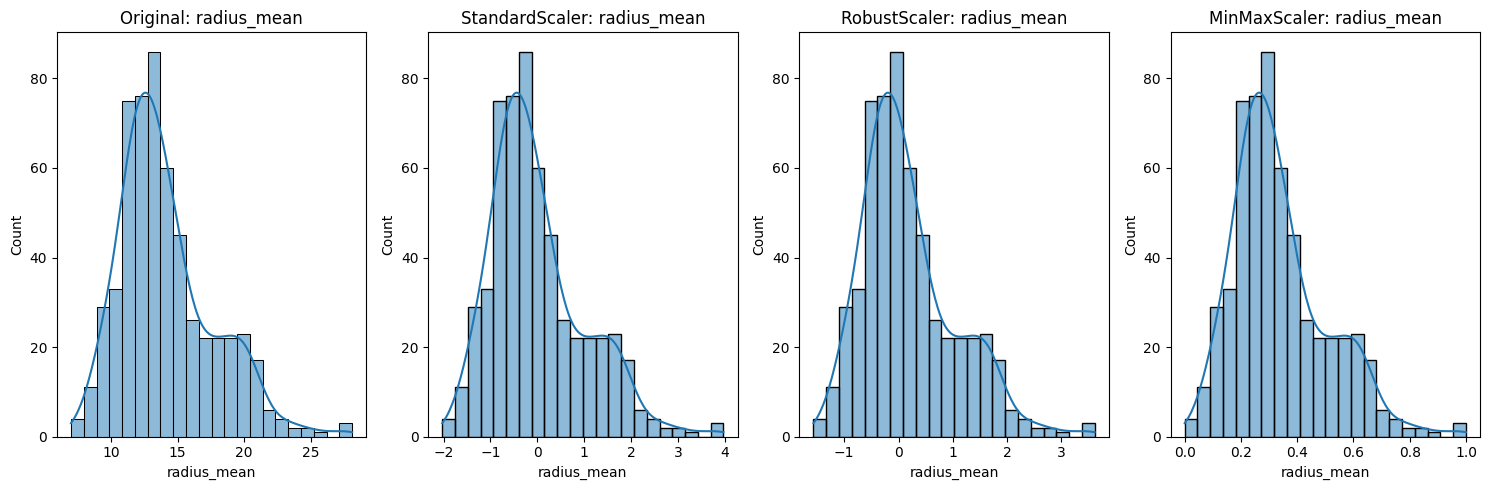

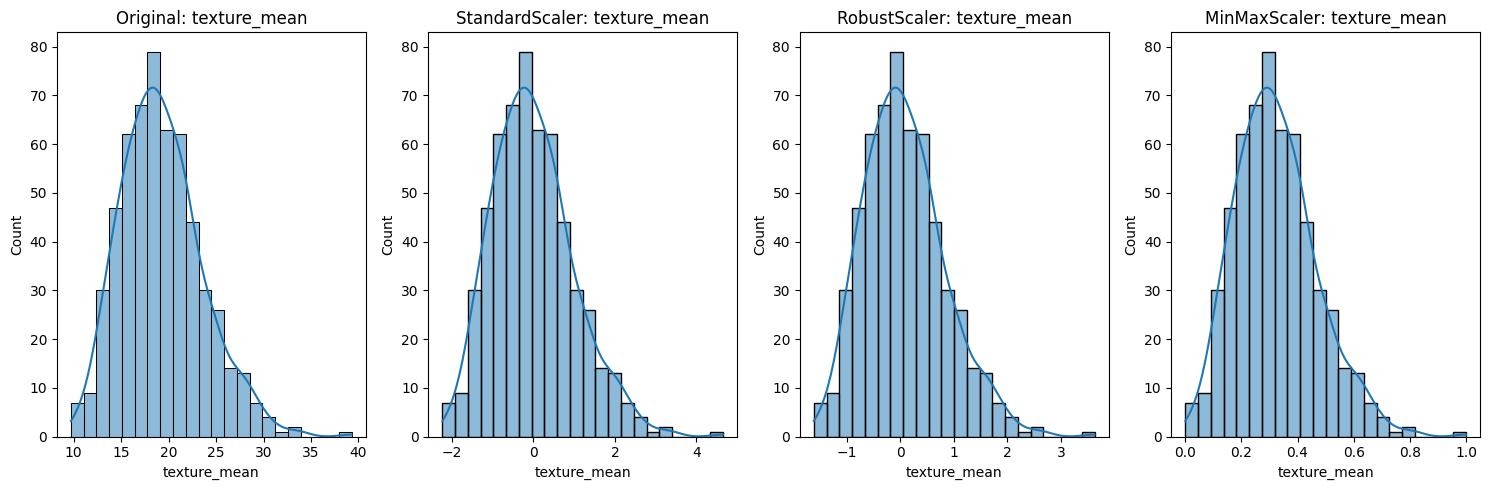

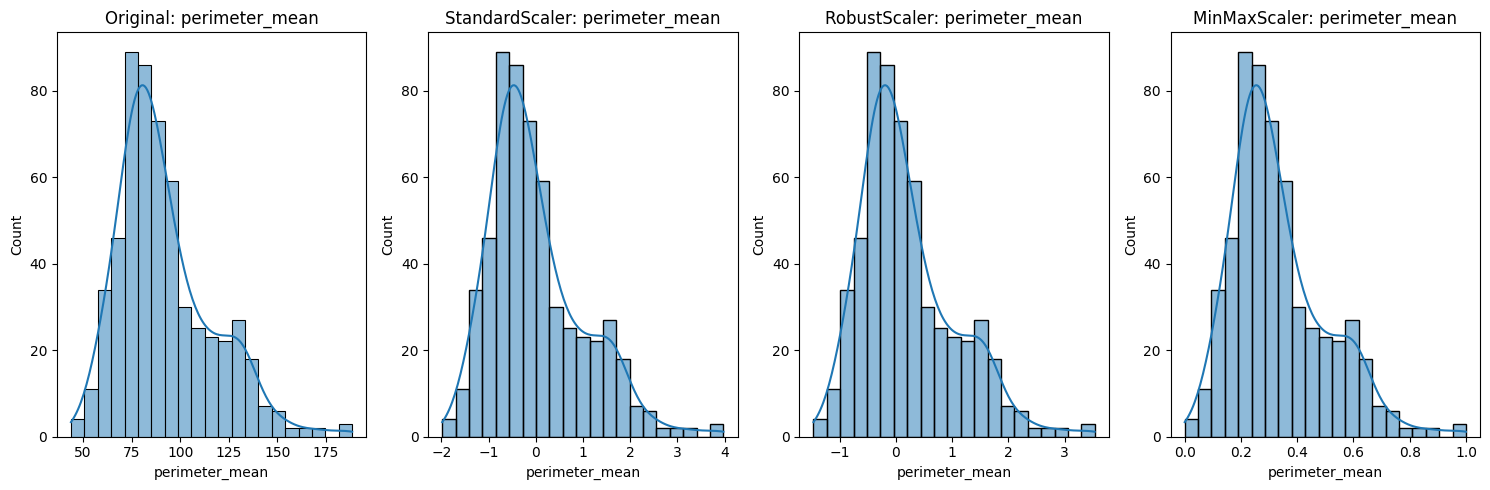

In [22]:
# Visualize the effect of different scaling methods on a few key features
key_features = ['radius_mean', 'texture_mean', 'perimeter_mean']

for feature in key_features:
    fig = plt.figure(figsize=(15, 5))
    
    # Original data distribution
    plt.subplot(1, 4, 1)
    sns.histplot(X[feature], kde=True)
    plt.title(f"Original: {feature}")
    plt.tight_layout()
    
    # Scaled data distributions
    for i, (scaler_name, X_scaled_df) in enumerate(scaled_data.items(), 2):
        plt.subplot(1, 4, i)
        sns.histplot(X_scaled_df[feature], kde=True)
        plt.title(f"{scaler_name}: {feature}")
    
    plt.tight_layout()
    plt.show()

Based on the visualizations, RobustScaler seems to handle outliers best for this dataset, which is important given the presence of outliers we observed in the data cleaning notebook. Let's proceed with RobustScaler for our preprocessing.

In [23]:
# Apply RobustScaler to our features
robust_scaler = RobustScaler()
X_scaled = robust_scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Features scaled using RobustScaler")
X_scaled_df.head()

Features scaled using RobustScaler


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,area_perimeter_ratio,radius_worst_mean_ratio,texture_worst_mean_ratio,perimeter_worst_mean_ratio,area_worst_mean_ratio
0,1.132353,-1.502664,1.263740,1.241446,1.190174,2.824832,2.358711,2.115850,1.855030,2.039192,...,2.364252,1.807750,1.715248,2.635556,1.884578,0.928899,3.202592,2.041194,3.701777,3.978960
1,1.764706,-0.190053,1.612859,2.138245,-0.587956,-0.213653,0.250742,0.682995,0.059172,-0.578385,...,-0.131839,0.055514,0.892194,-0.106667,0.435500,1.892412,1.039317,-0.007312,0.604760,1.171484
2,1.549020,0.428064,1.512617,1.798841,0.725304,1.027337,1.343287,1.758242,0.819527,-0.184086,...,1.107869,0.833458,1.483052,1.171852,0.365664,1.510597,0.842524,-0.681933,0.385756,0.889125
3,-0.477941,0.273535,-0.299343,-0.455298,2.463286,2.921045,1.778327,1.335444,2.381657,4.263658,...,3.410109,1.714605,1.633358,5.653333,4.508244,-0.746292,2.041166,-0.106748,1.403615,1.146777
4,1.696078,-0.799290,1.688904,2.058223,0.234020,0.613470,1.349219,1.318681,0.050296,-0.321853,...,-0.035956,0.645678,0.648595,-0.678519,-0.158099,1.693409,-0.108906,-0.908378,-0.081286,-0.179600


## Dimensionality Reduction with PCA

Let's apply Principal Component Analysis (PCA) to reduce dimensionality while preserving most of the variance in the data.

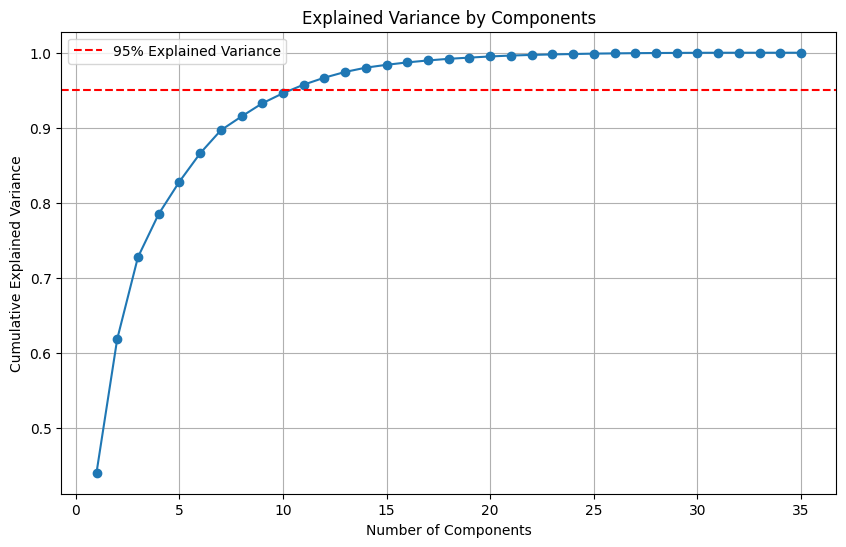

In [24]:
# Apply PCA and determine the optimal number of components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)

# Add a horizontal line at 95% explained variance
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

In [25]:
# Find the number of components needed to explain 95% of variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed to explain 95% variance: {n_components_95}")

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA components
pca_cols = [f"PC{i+1}" for i in range(n_components_95)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_cols)
X_pca_df.head()

Number of components needed to explain 95% variance: 11


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,10.065850,1.769735,-2.615925,-3.039222,-2.256473,-1.531757,-2.254485,0.267776,1.564100,0.728830,-0.138005
1,3.235823,-3.172995,-0.326711,1.079818,-0.450212,-0.485485,-0.031621,0.372059,-0.370828,1.427455,0.387660
2,5.359273,-0.402594,0.002779,0.901620,-1.198001,0.615433,0.133488,-0.030281,-0.693426,-0.051040,0.382052
3,4.334815,9.302410,-4.115407,-2.680098,-2.722457,2.553849,-1.557149,-1.403666,-1.257553,0.745872,-0.570168
4,4.116237,-0.950919,2.547637,1.579233,-1.639179,-0.959693,1.331855,0.834756,-0.349095,0.378491,-0.227449


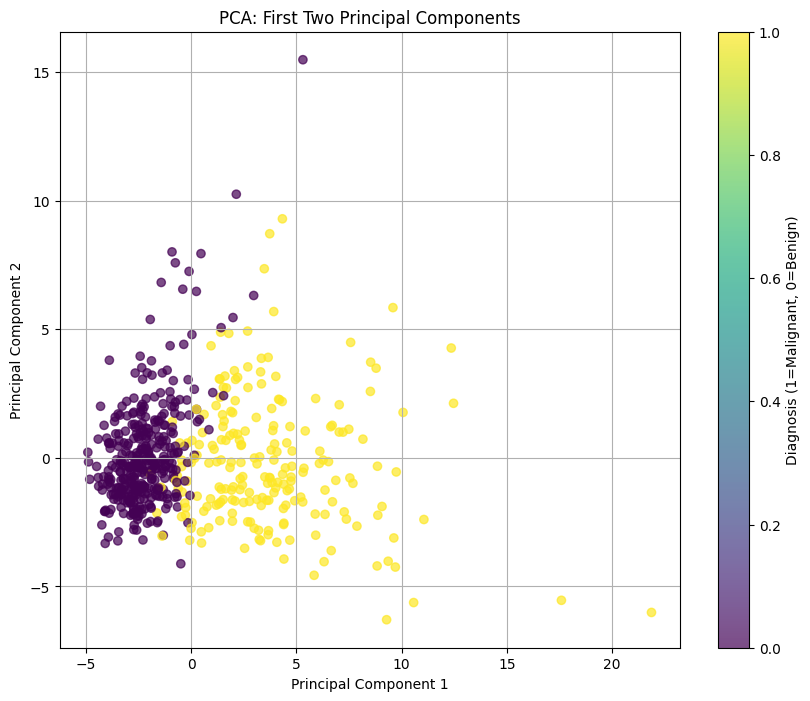

In [26]:
# Visualize the first two principal components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Diagnosis (1=Malignant, 0=Benign)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components')
plt.grid(True)
plt.show()

## Feature Selection

Let's apply different feature selection techniques to identify the most important features for our prediction task.

In [27]:
# Apply different feature selection techniques
# 1. ANOVA F-value for feature selection
k_best_anova = SelectKBest(score_func=f_classif, k=10)
X_kbest_anova = k_best_anova.fit_transform(X_scaled, y)
anova_selected_features = X.columns[k_best_anova.get_support()]

# 2. Mutual information for feature selection
k_best_mi = SelectKBest(score_func=mutual_info_classif, k=10)
X_kbest_mi = k_best_mi.fit_transform(X_scaled, y)
mi_selected_features = X.columns[k_best_mi.get_support()]

# 3. Recursive Feature Elimination with Random Forest
rf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=10)
X_rfe = rfe.fit_transform(X_scaled, y)
rfe_selected_features = X.columns[rfe.get_support()]

# Display selected features from each method
print("Top 10 features selected by ANOVA F-test:")
print(anova_selected_features.tolist())

print("\nTop 10 features selected by Mutual Information:")
print(mi_selected_features.tolist())

print("\nTop 10 features selected by Recursive Feature Elimination:")
print(rfe_selected_features.tolist())

Top 10 features selected by ANOVA F-test:
['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst', 'area_perimeter_ratio']

Top 10 features selected by Mutual Information:
['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']

Top 10 features selected by Recursive Feature Elimination:
['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst', 'area_worst_mean_ratio']


In [28]:
# Find common features across all selection methods
common_features = set(anova_selected_features) & set(mi_selected_features) & set(rfe_selected_features)
print(f"Common features across all methods: {list(common_features)}")

# Create a union set of important features
all_important_features = list(set(anova_selected_features) | set(mi_selected_features) | set(rfe_selected_features))
print(f"\nTotal unique important features: {len(all_important_features)}")

Common features across all methods: ['area_worst', 'concavity_mean', 'concave points_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'perimeter_mean', 'concave points_worst']

Total unique important features: 13


In [29]:
# Create a dataset with the selected features
# We'll use all unique important features identified by at least one method
X_selected = X_scaled_df[all_important_features]
print(f"Selected features dataset shape: {X_selected.shape}")
X_selected.head()

Selected features dataset shape: (569, 13)


,area_se,area_worst,concavity_mean,radius_mean,area_mean,perimeter_mean,texture_worst,area_perimeter_ratio,concave points_mean,area_worst_mean_ratio,perimeter_worst,radius_worst,concave points_worst
0,4.713606,2.343063,2.358711,1.132353,1.241446,1.263740,-0.935185,0.928899,2.115850,3.978960,2.105595,1.801038,1.715248
1,1.812363,2.232284,0.250742,1.764706,2.138245,1.612859,-0.231481,1.892412,0.682995,1.171484,1.480746,1.733564,0.892194
2,2.542063,1.797960,1.343287,1.549020,1.798841,1.512617,0.013889,1.510597,1.758242,0.889125,1.328167,1.487889,1.483052
3,0.098756,-0.208897,1.778327,-0.477941,-0.455298,-0.299343,0.126157,-0.746292,1.335444,1.146777,0.029305,-0.010381,1.633358
4,2.557059,1.562335,1.349219,1.696078,2.058223,1.688904,-1.011574,1.693409,1.318681,-0.179600,1.320901,1.309689,0.648595


## Train-Test Split

Let's split our data into training and testing sets. We'll create splits for both the scaled original data and the selected features.

In [30]:
# Split the data with original scaled features
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# Split the data with selected features
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    X_selected, y, test_size=0.25, random_state=42, stratify=y
)

# Split the data with PCA components
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y
)

# Print the shapes of the splits
print("Original scaled features:")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

print("\nSelected features:")
print(f"X_train_selected shape: {X_train_selected.shape}, X_test_selected shape: {X_test_selected.shape}")

print("\nPCA features:")
print(f"X_train_pca shape: {X_train_pca.shape}, X_test_pca shape: {X_test_pca.shape}")

Original scaled features:
X_train shape: (426, 35), X_test shape: (143, 35)
y_train shape: (426,), y_test shape: (143,)

Selected features:
X_train_selected shape: (426, 13), X_test_selected shape: (143, 13)

PCA features:
X_train_pca shape: (426, 11), X_test_pca shape: (143, 11)


## Handling Class Imbalance

Let's check if we have class imbalance in our target variable, and if so, address it using techniques like SMOTE (Synthetic Minority Over-sampling Technique).

Class distribution in training set:
diagnosis
0    267
1    159
Name: count, dtype: int64
Ratio of minority to majority class: 0.60


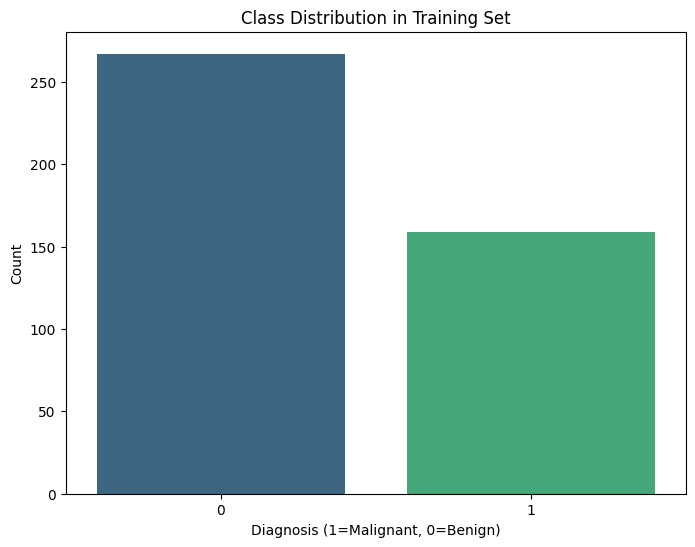

In [31]:
# Check class distribution in the training set
print("Class distribution in training set:")
print(y_train.value_counts())
print(f"Ratio of minority to majority class: {y_train.value_counts().iloc[1] / y_train.value_counts().iloc[0]:.2f}")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Diagnosis (1=Malignant, 0=Benign)')
plt.ylabel('Count')
plt.show()

In [32]:
# Apply SMOTE to handle class imbalance if needed
# Only apply if the imbalance ratio is less than 0.8
imbalance_ratio = y_train.value_counts().iloc[1] / y_train.value_counts().iloc[0]

if imbalance_ratio < 0.8:
    smote = SMOTE(random_state=42)
    
    # Apply SMOTE to the original scaled features
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Apply SMOTE to the selected features
    X_train_selected_resampled, y_train_selected_resampled = smote.fit_resample(X_train_selected, y_train_selected)
    
    # Apply SMOTE to the PCA features
    X_train_pca_resampled, y_train_pca_resampled = smote.fit_resample(X_train_pca, y_train_pca)
    
    # Print the shapes after resampling
    print("After applying SMOTE:")
    print(f"X_train_resampled shape: {X_train_resampled.shape}")
    print(f"Class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts()}")
else:
    print("Class imbalance is not severe. SMOTE not applied.")
    X_train_resampled, y_train_resampled = X_train, y_train
    X_train_selected_resampled, y_train_selected_resampled = X_train_selected, y_train_selected
    X_train_pca_resampled, y_train_pca_resampled = X_train_pca, y_train_pca

After applying SMOTE:
X_train_resampled shape: (534, 35)
Class distribution after SMOTE: diagnosis
0    267
1    267
Name: count, dtype: int64


## Saving Preprocessed Data

Let's save the preprocessed datasets for use in our modeling notebook.

In [33]:
# Create a dictionary to store all our preprocessed datasets
preprocessed_data = {
    'X_train': X_train_resampled,
    'X_test': X_test,
    'y_train': y_train_resampled,
    'y_test': y_test,
    'X_train_selected': X_train_selected_resampled,
    'X_test_selected': X_test_selected,
    'y_train_selected': y_train_selected_resampled,
    'y_test_selected': y_test_selected,
    'X_train_pca': X_train_pca_resampled,
    'X_test_pca': X_test_pca,
    'y_train_pca': y_train_pca_resampled,
    'y_test_pca': y_test_pca,
    'feature_names': X.columns.tolist(),
    'selected_feature_names': all_important_features,
    'pca_components': n_components_95,
    'robust_scaler': robust_scaler,
    'pca_model': pca
}

# Save the preprocessed data using numpy
np.save('../data/breast_cancer_preprocessed_data.npy', preprocessed_data, allow_pickle=True)
print("Preprocessed data saved as '../data/breast_cancer_preprocessed_data.npy'")

Preprocessed data saved as '../data/breast_cancer_preprocessed_data.npy'


## Summary and Next Steps

In this notebook, we've performed comprehensive preprocessing of the breast cancer dataset:

- Loaded the cleaned and feature-engineered data
- Applied different scaling techniques and selected RobustScaler as the most appropriate for our dataset
- Applied dimensionality reduction with PCA, preserving 95% of the variance
- Selected important features using multiple techniques (ANOVA, Mutual Information, RFE)
- Split the data into training and testing sets
- Addressed class imbalance using SMOTE if needed
- Saved the preprocessed data for modeling

Next Steps:
- Train different machine learning models on the preprocessed data
- Evaluate model performance using appropriate metrics
- Optimize hyperparameters for the best-performing models
- Select the final model for breast cancer prediction

In [34]:
# Data preprocessing completed
print("Data preprocessing completed!")

Data preprocessing completed!
